
# MAGA Arlequin Dataset Analysis

This notebook provides an exhaustive analysis of the `MAGAArlequinDataset`. We will explore:
1.  **Hyperedge Inference**: How different ranks (relationships) are constructed.
2.  **Hyperedge Statistics**: Distribution of sizes and counts.
3.  **Feature Computation**: How initial features for nodes and hyperedges are derived.


In [38]:

import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from omegaconf import OmegaConf
from topobench.data.datasets.maga_arlequin import MAGAArlequinDataset

# Configure plotting
sns.set_theme(style="whitegrid")
%matplotlib inline



## 1. Load Dataset

We initialize the dataset with default parameters. We call `get_connectivity()` to ensure that the internal lists of hyperedges (users, interactions, communities, semantic clusters) are populated.


In [ ]:

# Define parameters matching the default used in the class
params = OmegaConf.create({
    "cluster_level_posts": -2,
    "cluster_level_users": 0,
    "max_rank": 4,
    "cluster_seed": 42,
    "neighborhoods": None,
    "max_posts_per_user": 10000,
    
})

root_dir = "./maga_analysis_data"
dataset_name = "MAGA_Arlequin"

print("Loading dataset...")
dataset = MAGAArlequinDataset(root=root_dir, name=dataset_name, parameters=params)

# Force computation of connectivity to get the internal attributes populated
dataset.get_connectivity()
print("Dataset loaded and connectivity computed.")


Loading dataset...


/home/gbg141/.conda/envs/tb/lib/python3.11/site-packages/torch_geometric/io/fs.py:229: UserWarning: Weights only load failed. Please file an issue to make `torch.load(weights_only=True)` compatible in your case. Please use `torch.serialization.add_safe_globals([scalar])` to allowlist this global.
  warnings.warn(f"{warn_msg} Please use "


Users:  [7]
Embeddings:  [7094, 683, 74, 5]
Dataset loaded and connectivity computed.



## 2. Hyperedge Analysis by Rank

The dataset constructs a **Colored Hypergraph** (Combinatorial Complex) with 5 levels of hierarchy (ranks 0 to 4). We analyze each level using the raw data structures stored in the dataset object.



### Rank 0: Posts (Nodes)

**Definition**: These are the fundamental units of the graph, representing individual Twitter posts.
**Inference**: Directly from the input dataframe rows.
**Feature ($x_0$)**: 1024-dimensional BERT-based embeddings of the post content.


In [40]:

# Rank 0 Analysis
n_posts = dataset._data.x_0.shape[0]
print(f"Number of Posts (Rank 0): {n_posts}")

# Feature Analysis
x_0 = dataset._data.x_0
print(f"Feature Matrix x_0 shape: {x_0.shape}")


Number of Posts (Rank 0): 39079
Feature Matrix x_0 shape: torch.Size([39079, 1024])



### Rank 1: Users

**Definition**: Represents a Twitter user.
**Inference**: A User hyperedge consists of **all posts created by that user**.
**Feature ($x_1$)**: 1024-dimensional embedding of the user's biography.


Number of users: 39
Number of posts per user: [489, 265, 1413, 1042, 2185, 714, 714, 2742, 2591, 1013, 401, 2300, 1658, 169, 292, 282, 273, 275, 2050, 1265, 729, 258, 87, 32, 23, 152, 46, 226, 60, 88, 14748, 180, 125, 68, 21, 38, 48, 10, 7]


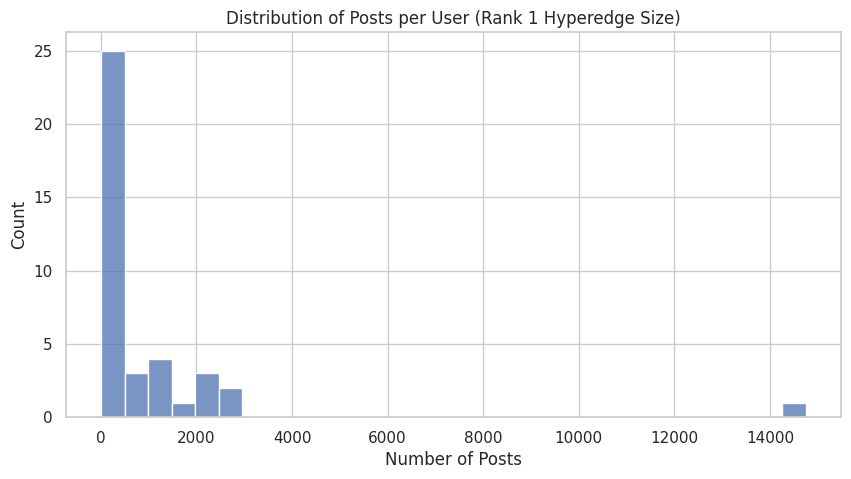

In [41]:

# Rank 1 Analysis
# Users are keys in users_to_posts
n_users = len(dataset.users_to_posts)
print(f"Number of users: {n_users}")
user_sizes = [len(posts) for posts in dataset.users_to_posts.values()]
print(f"Number of posts per user: {user_sizes}")

if user_sizes:
    plt.figure(figsize=(10, 5))
    sns.histplot(user_sizes, bins=30, kde=False)
    plt.title("Distribution of Posts per User (Rank 1 Hyperedge Size)")
    plt.xlabel("Number of Posts")
    plt.ylabel("Count")
    plt.show()



### Rank 2: Interactions

**Definition**: Represents a conversation thread.
**Inference**: An Interaction hyperedge contains a **root post and all its descendants** (replies, replies to replies) in a thread. It is only formed if the thread contains more than one post and involves multiple unique authors.
**Feature ($x_2$)**: Average of the bio-embeddings of all unique users participating in the interaction.


Number of interactions: 252
Interaction sizes: [2, 2, 2, 4, 2, 2, 6, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 5, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 3, 6, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 4, 2, 4, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 3, 2, 3, 3, 4, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 3, 3, 2, 5, 2, 2, 3, 2, 2, 2, 5, 5, 4, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 5, 2, 2, 3, 2, 2, 2, 3, 3, 4, 3, 4, 4, 4, 2, 2, 2, 2, 5, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 4, 4, 2, 2, 3, 5, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 3, 3, 2, 2, 2, 3, 3, 2, 4, 2, 2, 3, 2, 2, 3, 5, 3, 2, 2, 5, 2, 2, 2, 2, 2, 5, 3, 2, 2, 3, 2, 2, 3, 3, 3, 2, 3, 2, 2, 2, 2, 3, 2, 3, 2, 3, 3, 5, 2, 4, 2, 2, 3, 2, 3, 3, 2, 4, 2, 3, 2, 3, 4, 3, 4, 2, 3, 2, 3, 2, 4, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 5, 2]


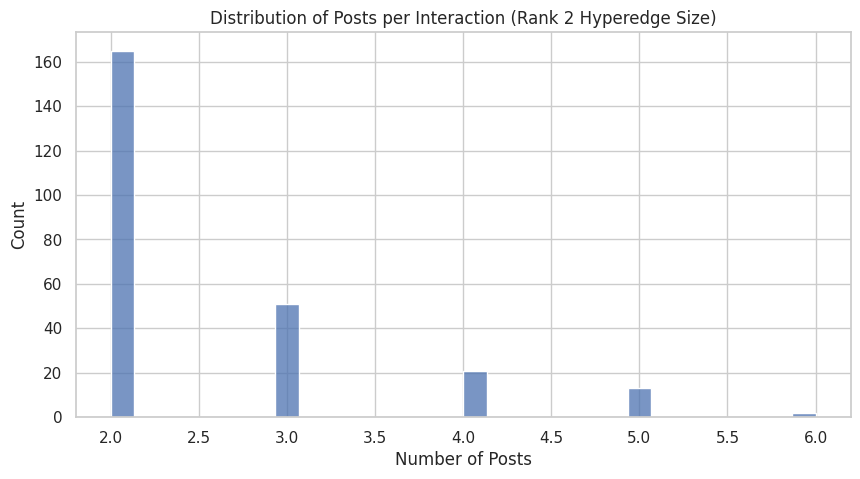

In [42]:

# Rank 2 Analysis
n_interactions = len(dataset.interactions)
print(f"Number of interactions: {n_interactions}")
# dataset.interactions stores tnx.HyperEdge objects
interaction_sizes = [len(interaction) for interaction in dataset.interactions]
print(f"Interaction sizes: {interaction_sizes}")

if interaction_sizes:
    plt.figure(figsize=(10, 5))
    sns.histplot(interaction_sizes, bins=30, kde=False)
    plt.title("Distribution of Posts per Interaction (Rank 2 Hyperedge Size)")
    plt.xlabel("Number of Posts")
    plt.ylabel("Count")
    plt.show()


In [46]:

# Interaction Post Coverage Analysis
# Calculate Ratio of posts that appear in at least one interaction
unique_interaction_posts = set()
for interaction in dataset.interactions:
    # interaction is iterable (HyperEdge) yielding Post objects
    for post in interaction:
        unique_interaction_posts.add(post.id)

coverage_count = len(unique_interaction_posts)
total_posts = len(dataset.posts)
coverage_ratio = coverage_count / total_posts if total_posts > 0 else 0

print(f"Interaction Post Coverage: {coverage_ratio:.2%} ({coverage_count}/{total_posts} posts)")


# Interaction Author Coverage Analysis
# Calculate Ratio of users (authors) that participate in at least one interaction
unique_interaction_authors = set()
for interaction in dataset.interactions:
    # interaction is iterable (HyperEdge) yielding Post objects
    for post in interaction:
        unique_interaction_authors.add(post.user_id)

coverage_author_count = len(unique_interaction_authors)
# Total users can be derived from the existing users_to_posts dictionary
total_authors = len(dataset.users_to_posts)
coverage_author_ratio = coverage_author_count / total_authors if total_authors > 0 else 0

print(f"Interaction Author Coverage: {coverage_author_ratio:.2%} ({coverage_author_count}/{total_authors} users)")

Interaction Post Coverage: 1.65% (644/39079 posts)
Interaction Author Coverage: 92.31% (36/39 users)



### Rank 3: Communities

**Definition**: Groups of similar users.
**Inference**: Users are clustered based on their **bio-embeddings** using the FINCH clustering algorithm. A Community hyperedge contains **all posts from all users** in that cluster.
**Feature ($x_3$)**: Average of the bio-embeddings of all users in the community.


Number of communities: 7
Community sizes: [3609, 1309, 22948, 3941, 3072, 3851, 349]


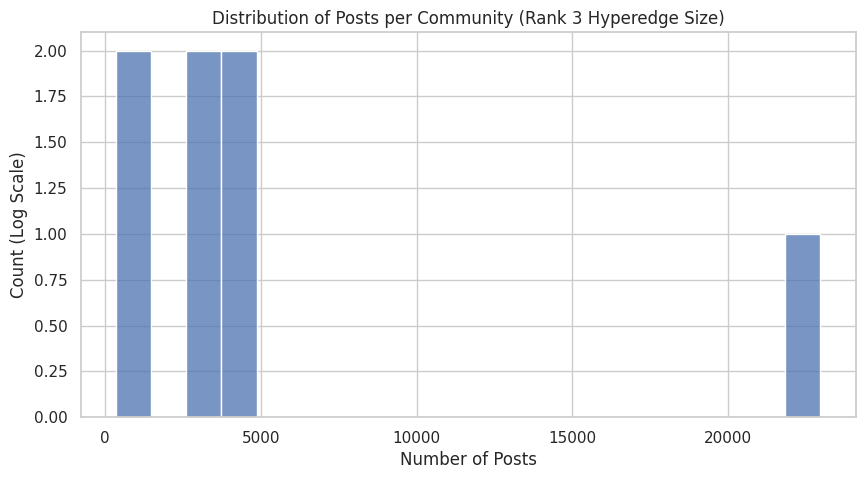

In [32]:

# Rank 3 Analysis
n_communities = len(dataset.community_hyperedges)
print(f"Number of communities: {n_communities}")
# dataset.community_hyperedges stores list of posts
community_sizes = [len(posts) for posts in dataset.community_hyperedges]
print(f"Community sizes: {community_sizes}")

if community_sizes:
    plt.figure(figsize=(10, 5))
    sns.histplot(community_sizes, bins=20, kde=False)
    plt.title("Distribution of Posts per Community (Rank 3 Hyperedge Size)")
    plt.xlabel("Number of Posts")
    plt.ylabel("Count (Log Scale)")
    plt.show()



### Rank 4: Semantic Clusters

**Definition**: Semantic groupings of posts.
**Inference**: Posts are directly clustered based on their **content embeddings** using FINCH. A Semantic hyperedge contains **all posts** belonging to that semantic cluster.
**Feature ($x_4$)**: One-hot encoding of the cluster ID (identity matrix).


Number of semantic hyperedges: 74
Semantic sizes: [414, 9821, 2272, 12354, 322, 125, 453, 2157, 759, 33, 450, 22, 337, 116, 269, 108, 897, 15, 18, 21, 339, 52, 199, 117, 21, 180, 140, 151, 38, 48, 1356, 139, 74, 173, 405, 40, 1470, 332, 65, 380, 52, 135, 57, 145, 170, 96, 14, 11, 212, 51, 46, 87, 61, 59, 165, 25, 12, 25, 38, 33, 119, 59, 83, 40, 17, 17, 62, 68, 66, 193, 20, 37, 99, 23]


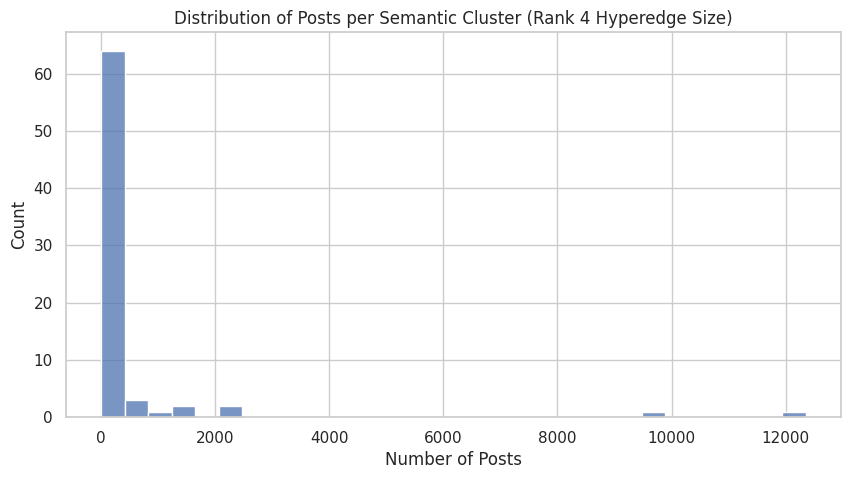

In [36]:

# Rank 4 Analysis
n_semantics = len(dataset.semantic_hyperedges)
print(f"Number of semantic hyperedges: {n_semantics}")
# dataset.semantic_hyperedges stores list of posts
semantic_sizes = [len(posts) for posts in dataset.semantic_hyperedges]
print(f"Semantic sizes: {semantic_sizes}")

if semantic_sizes:
    plt.figure(figsize=(10, 5))
    sns.histplot(semantic_sizes, bins=30, kde=False)
    plt.title("Distribution of Posts per Semantic Cluster (Rank 4 Hyperedge Size)")
    plt.xlabel("Number of Posts")
    plt.ylabel("Count")
    plt.show()



## 3. Comprehensive Statistical Summary

We present a unified table containing the statistics (Count, and Hyperedge Size stats: Mean, Median, Std, Min, Max) for each rank.


In [37]:

stats = []

# Rank 0 (Posts) - Size is effectively 1 (singular nodes)
x_0 = dataset.data.x_0
stats.append({
    "Rank": 0,
    "Type": "Posts",
    "Count": len(dataset.posts),
    "Size Mean": 1.0, "Size Median": 1.0, "Size Std": 0.0, "Size Min": 1, "Size Max": 1,
    "Feature Dim": x_0.shape[1]
})

# Ranks 1-4
# Define a helper to extract sizes based on the dataset attributes we accessed above
rank_data = [
    (1, "Users", dataset.data.x_1, [len(posts) for posts in dataset.users_to_posts.values()]),
    (2, "Interactions", dataset.data.x_2, [len(interaction) for interaction in dataset.interactions]),
    (3, "Communities", dataset.data.x_3, [len(posts) for posts in dataset.community_hyperedges]),
    (4, "Semantic Clusters", dataset.data.x_4, [len(posts) for posts in dataset.semantic_hyperedges])
]

for r, label, feat, sizes in rank_data:
    if len(sizes) > 0:
        stats.append({
            "Rank": r,
            "Type": label,
            "Count": len(sizes),
            "Size Mean": np.mean(sizes),
            "Size Median": np.median(sizes),
            "Size Std": np.std(sizes),
            "Size Min": np.min(sizes),
            "Size Max": np.max(sizes),
            "Feature Dim": feat.shape[1]
        })
    else:
        stats.append({
            "Rank": r,
            "Type": label,
            "Count": 0,
            "Size Mean": 0, "Size Median": 0, "Size Std": 0, "Size Min": 0, "Size Max": 0,
            "Feature Dim": feat.shape[1]
        })

df_stats = pd.DataFrame(stats)

# Styling
pd.options.display.float_format = '{:,.2f}'.format

styled_df = df_stats.style.background_gradient(cmap='Blues', subset=['Count', 'Size Mean', 'Size Max'])\
    .highlight_max(subset=['Count', 'Size Max'], color='lightgreen', axis=0)\
    .set_caption("Hypergraph Statistics by Rank")\
    .format({
        'Size Mean': '{:.2f}',
        'Size Median': '{:.1f}',
        'Size Std': '{:.2f}',
        'Count': '{:.0f}',
        'Size Min': '{:.0f}',
        'Size Max': '{:.0f}'
    })

display(styled_df)


/home/gbg141/.conda/envs/tb/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


,Rank,Type,Count,Size Mean,Size Median,Size Std,Size Min,Size Max,Feature Dim
0,0,Posts,39079,1.00,1.0,0.00,1,1,1024
1,1,Users,39,1002.03,273.0,2363.65,7,14748,1024
2,2,Interactions,252,2.56,2.0,0.90,2,6,1024
3,3,Communities,7,5582.71,3609.0,7202.21,349,22948,1024
4,4,Semantic Clusters,74,528.09,91.5,1821.57,11,12354,74
